<a href="https://colab.research.google.com/github/meysamalishahi/ReinforcementLearning/blob/master/Chapter%206/Cliff_Walking_(Example_6_6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Example 6.6: Cliff Walking 
This gridworld example compares Sarsa and Q-learning, highlighting the difference between on-policy (Sarsa) and off-policy (Q-learning) methods. Consider the gridworld shown to the right. This is a standard undiscounted, episodic task, with start SaferRpath and goal states, and the usual actions causing movement up, down, Optimal path right, and left. Reward is $-1$ on all transitions except those into the region marked “The Cliff.” Stepping into this region incurs a reward of $-100$ and sends the agent instantly back to the start.
![Cliff](https://drive.google.com/file/d/1RhWzdkd4QksTqoCT2lxOn0AdzOONxEkb/view?usp=sharing)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d
from itertools import product 
from termcolor import colored
from matplotlib import colors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class Environment:
  def __init__(self, size, startpoint, endpoint, actions, cliff_area):
    self.m, self.n = size
    self.actions = actions
    self.endpoint = endpoint
    self.startpoint = startpoint
    self.cliff_area = cliff_area

  def step(self, position, action):
    if action not in self.actions:
      raise Exception("The action (%s,%s) is not allowed!!" %action)

    reward = -1
    Done = False
    r, c = position
    a, b = action
    new_r, new_c = r-a, c+b

    if (new_r, new_c) in self.cliff_area:
      return self.startpoint, -100, False

    if new_c > self.n-1:
      new_c = self.n-1
    elif new_c < 0:
      new_c = 0 

    if new_r > self.m - 1:
      new_r = self.m - 1
    elif new_r < 0:
      new_r = 0   

    if (new_r, new_c) == self.endpoint:
      reward = 0
      Done = True
       
    return (new_r, new_c), reward, Done


In [3]:
Arrow = {}
Arrow[(0,0)] = '.'
Arrow[(0,-1)] = '\u2190' #Leftwards Arrow
Arrow[(1,0)] = '\u2191' #Upwards Arrow
Arrow[(0,1)] = '\u2192' #Rightwards Arrow
Arrow[(-1,0)] = '\u2193' #Downwards Arrow
Arrow[(1,-1)] = '\u2196' #North West Arrow
Arrow[(1,1)] = '\u2197' #North East Arrow
Arrow[(-1,1)] = '\u2198' #South East Arrow
Arrow[(-1,-1)] = '\u2199' #South West Arrow

In [4]:
class CliffWalking:
  def __init__(self, Env, n_iters = 100, n_steps =1,
               gamma = 1, eps = .1, alpha = .1, Type =  'Sarsa'):
    self.Type = Type
    self.Env = Env
    self.actions = Env.actions
    self.behaiviar_policy = {}
    self.Q = {}
    for x in range(Env.m):
      for y in range(Env.n):
        if (x,y) != Env.endpoint and (x,y) not in self.Env.cliff_area:
          self.behaiviar_policy[(x,y)] = [1/len(Env.actions) for _ in Env.actions]
          self.Q[(x,y)] = {}
          for action in Env.actions:
            self.Q[(x,y)][action] = 0

    sum_episodes_length = 0
    t1 = t = time.time()
    self.episode_history = []
    
    st = 1
    for x in range(1, n_iters+1): 
      cnt = 0            
      state = Env.startpoint
      Done = False
      SARSAlist = []
      G = 0
      reward = 0
      while len(SARSAlist) < n_steps and not Done:
        action = self.apply_behaiviar_policy(state)
        next_state, reward, Done = Env.step(state, action)
        SARSAlist.append((state, action, reward))
        G += gamma**(cnt) * reward
        state = next_state
        cnt += 1
        sum_episodes_length += 1

      while  len(SARSAlist) > 0:                              
        s, a, r = SARSAlist.pop(0)
        if not Done:
          cnt += 1
          action = self.apply_behaiviar_policy(state)
          next_state, reward, Done = Env.step(state, action)
          SARSAlist.append((state, action, reward))
          if Type == 'Sarsa':
            temp = G + gamma**n_steps * self.Q[state][action]
          elif Type == 'Q-learning':
            temp = G + gamma**n_steps * max(self.Q[state].values())
          elif Type == 'Expected-Sarsa':
            temp = G + gamma**n_steps * self.expected_sarsa(state)
          else:
            raise Exception("Unknown Type!! Valid types are: Sarsa, Q-learning, and Expected-Sarsa.")
          state = next_state
          G = (G-r)/gamma + gamma**(n_steps-1) * reward
          sum_episodes_length += 1
        else:
          temp = G
          G = (G-r)/gamma
        self.Q[s][a] = self.Q[s][a] + alpha * (temp - self.Q[s][a])
        self.update_behaiviar_policy(eps, state = s)
      
      if x % 10 == 0:
        self.episode_history.append(sum_episodes_length/x)
                      
    print(colored('Ended in %s seconds', 'white', 'on_grey') %(time.time() - t))


  def expected_sarsa(self, state):
    P = self.behaiviar_policy[state]
    mu = 0
    for i, a in enumerate(self.actions):
      mu += P[i]*self.Q[state][a]
    return mu

  def apply_behaiviar_policy(self, state):
    probabilities = self.behaiviar_policy[state]
    index = np.random.choice(range(len(self.actions)), p = probabilities)
    next_action = self.actions[index]
    return next_action
        

  def update_behaiviar_policy(self, eps, state = None):
    if state is None:
      States = self.states
    else:
      States = [state]
    for s in States:
      Max = max(self.Q[s].values())
      index = np.random.choice([x for x in range(len(self.actions))
                                if self.Q[s][self.actions[x]] >= Max])
                    
      best_action = self.actions[index]
      for idx in range(len(self.actions)):
        if best_action == self.actions[idx]:
          self.behaiviar_policy[s][idx] = 1 - eps + eps/len(self.actions)
        else:
          self.behaiviar_policy[s][idx] = eps/len(self.actions) 

  def get_optimal_policy(self):
    for state in self.behaiviar_policy.keys():
      idx = np.argmax(self.behaiviar_policy[state])
      self.target_policy[state] = self.actions[idx]

  def bulid_trajectory(self, point):
    Done = False 
    tr = []
    state = point
    while not Done:
      action = self.actions[np.argmax(self.behaiviar_policy[state])]
      tr.append((state, action))
      state, _, Done = Env.step(state, action)
    return tr

  def plot_optimal_policy(self):
    plt.subplots(figsize = (15,15))
    Matrix = np.zeros((self.Env.m, self.Env.n)).astype(int)
    Matrix[self.Env.startpoint] = 1
    Matrix[self.Env.endpoint] = 2
    for pos in self.Env.cliff_area:
      Matrix[pos] = 3
    trajectory = self.bulid_trajectory(self.Env.startpoint)
    action_trace = {}
    for i, point in enumerate(trajectory):
        action_trace[point[0]] = Arrow[point[1]]
        if point[0] != self.Env.startpoint:
          Matrix[point[0]] = -i-1
    show_annot_array = Matrix < 0
    show_annot_array[self.Env.startpoint] = True
    cmap = colors.ListedColormap(['yellow','green','blue','red' ,'black'])
    bounds=[-100, -0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = sns.heatmap(Matrix, cmap=cmap, annot=True, annot_kws={"size":20},
                      linewidth=0.05, linecolor ='black', xticklabels=False, 
                      yticklabels=False, norm = norm, cbar= False, square = True )
    fig.set_title("Optimal Policy: " + self.Type , fontsize=25)
    for text, position in zip(fig.texts, ((u,v) for u in range(self.Env.m) for v in range(self.Env.n))):
        if self.Env.startpoint == position:
          text.set_text(str(action_trace[position])+'\n Start')
        elif show_annot_array[position] == True:
          text.set_text(str(action_trace[position])+'\n '+ str(np.abs(Matrix[position])))
        elif self.Env.endpoint == position:
          text.set_text('Goal')
          show_annot_array[position] = True

        text.set_visible(show_annot_array[position])
    
    plt.show()
    plt.close()    

## Q-Learning

Ended in 1.9267938137054443 seconds


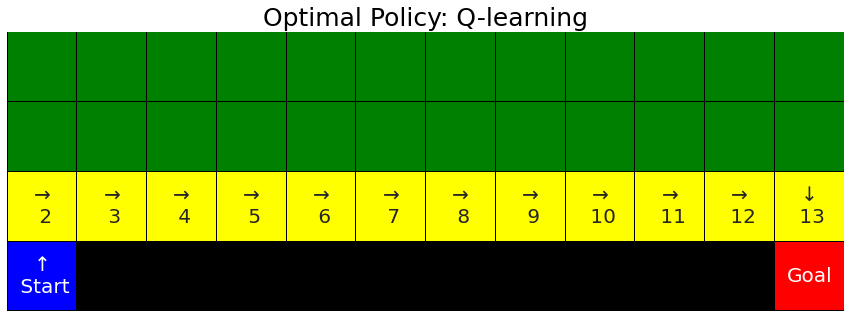

In [5]:
actions=[(0,1), (1,0), (0,-1), (-1,0)]
cliff_area = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8), (3,9), (3,10)]
Env = Environment(size = (4,12), startpoint = (3,0), endpoint = (3,11), 
                 actions = actions, cliff_area = cliff_area)
result = CliffWalking(Env = Env, eps = .3, n_iters = 500, n_steps = 1, Type = 'Q-learning')
result.plot_optimal_policy()

## Sarsa

Ended in 1.2604613304138184 seconds


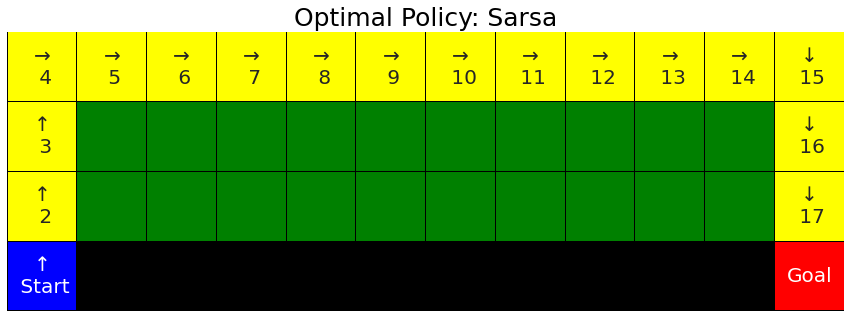

In [6]:
actions=[(0,1), (1,0), (0,-1), (-1,0)]
cliff_area = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8), (3,9), (3,10)]
Env = Environment(size = (4,12), startpoint = (3,0), endpoint = (3,11), 
                 actions = actions, cliff_area = cliff_area)
result = CliffWalking(Env = Env, eps= .3, alpha=.1, n_iters = 500, n_steps = 1, Type = 'Sarsa')
result.plot_optimal_policy()

## Expected-Sarsa

Ended in 1.6402223110198975 seconds


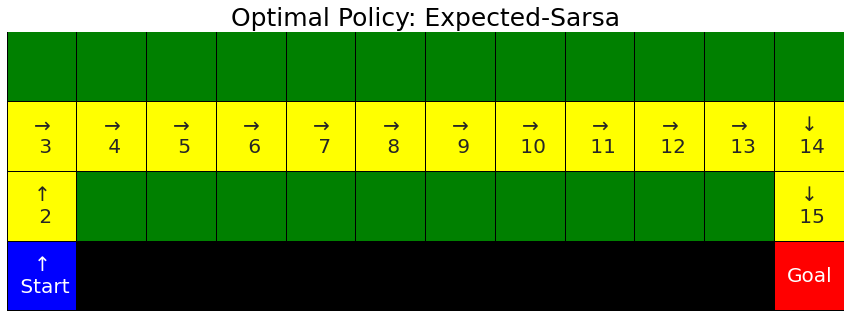

In [7]:
actions=[(0,1), (1,0), (0,-1), (-1,0)]
cliff_area = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8), (3,9), (3,10)]
Env = Environment(size = (4,12), startpoint = (3,0), endpoint = (3,11), 
                 actions = actions, cliff_area = cliff_area)
result = CliffWalking(Env = Env, eps= .2, n_iters = 1000, n_steps = 1, Type = 'Expected-Sarsa')
result.plot_optimal_policy()